In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 70

# Use datatable to read in large datasets quickly
!pip install datatable > /dev/null
import datatable as dt
papers_dt = dt.fread('../input/nips-papers-1987-2019-updated/papers.csv')
papers = papers_dt.to_pandas()
del papers_dt

display(papers.head(7))

,source_id,year,title,abstract,full_text
0,27,1987,Bit-Serial Neural Networks,NaN,"573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan F. Murray, Anthon..."
1,63,1987,Connectivity Versus Entropy,NaN,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S. Abu-Mostafa \n\nC...
2,60,1987,The Hopfield Model with Multi-Level Neurons,NaN,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL NEURONS \n\nMichael F...
3,59,1987,How Neural Nets Work,NaN,442 \n\nAlan Lapedes \nRobert Farber \n\nTheoretical Division \n...
4,69,1987,Spatial Organization of Neural Networks: A Probabilistic Modeling ...,NaN,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn~ORKS: \n\nA PROBABI...
5,6,1987,A Neural-Network Solution to the Concentrator Assignment Problem,NaN,775 \n\nA NEURAL-NETWORK SOLUTION TO THE CONCENTRATOR \n\nASSI...
6,33,1987,LEARNING BY STATE RECURRENCE DETECTION,NaN,642 \n\nLEARNING BY ST ATE RECURRENCE DETECfION \n\nBruce E. Rosen...


In [2]:
print('Shape of papers dataset:', papers.shape)

Shape of papers dataset: (9680, 5)


# 1. Data preprocessing and cleaning

We are going to fill in the null values in 3 columns: `title`, `abstract`, and `full_text` with an empty string ('') and convert that empty string (which is a float value) to a string.   

**Note:** We could also use *.astype(str)*.

In [3]:
papers.title = papers.title.fillna('').apply(str)
papers.abstract = papers.abstract.fillna('').apply(str)
papers.full_text = papers.full_text.fillna('').apply(str)

Let us look at the number of null values in the dataset before any preprocessing:

In [4]:
print('Number of papers with no abstract:', (papers.abstract.values == '').sum())
print('Number of papers with no full-text:', (papers.full_text.values == '').sum())

Number of papers with no abstract: 3319
Number of papers with no full-text: 3


We are now going to process the full-text step by step to:  
(1) extract useful information; and  
(2) remove unwanted information.
***
First, we are going to extract the abstract from the full-text by analyzing the various patterns that authors use in numbering and/or naming the sections following the abstract.  
One can easily observe that there are many patterns used by the authors, but in code cell [8] we only use 5 patterns given in `abstract_intro_patterns`.

In [5]:
import re

print('First 1000 characters in the full-text of the 1st paper:')
text = papers.loc[0, 'full_text'][:1100]
print(text)

First 1000 characters in the full-text of the 1st paper:
573 

BIT - SERIAL NEURAL  NETWORKS 

Alan F.  Murray,  Anthony V . W.  Smith  and Zoe F.  Butler. 

Department of Electrical Engineering,  University of Edinburgh, 

The King's Buildings, Mayfield Road,  Edinburgh, 

Scotland,  EH93JL. 

ABSTRACT 

A  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a 
synapse array through to silicon layout and board design.  The issues surrounding bit 
- serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel 
development  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and 
recall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected 
specification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173)
nique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms, 
using  a  "paging"  technique  t

**Note:** We include the `flags = re.IGNORECASE` parameter because the authors vary in their usage of the capitalization of the text (i.e., some use Abstract, some use ABSTRACT), and this flag ignores all such cases while searching for a match.

In [6]:
print('TEXT BETWEEN ABSTRACT AND INFORMATION in the 1st paper:')
abstract_intro = '(?s)ABSTRACT(.*?)1. INTRODUCTION'
re.findall(abstract_intro, text, flags = re.IGNORECASE)

TEXT BETWEEN ABSTRACT AND INFORMATION in the 1st paper:


[' \n\nA  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a \nsynapse array through to silicon layout and board design.  The issues surrounding bit \n- serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel \ndevelopment  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and \nrecall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected \nspecification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173)\nnique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms, \nusing  a  "paging"  technique  to  time  - multiplex  calculations  through  the  synapse \narray. \n\n']

In [7]:
text2 = papers.loc[2, 'full_text'][:2000]

abstract_intro = '(?s)ABSTRACT(.*?)I. INTRODUCTION'
liste = re.findall(abstract_intro, text2, flags = re.IGNORECASE)
liste[0]

' \n\nThe  Hopfield  neural  network.  model  for  associative  memory  is  generalized.  The  generalization \n\nreplaces  two  state  neurons by neurons taking a  richer set of values.  Two  classes  of neuron  input output \n\nrelations are developed guaranteeing convergence to stable states.  The first is a class of "continuous" rela-\n\ntions and the second is a class of allowed quantization rules for the neurons.  The information capacity for \n\nnetworks from  the second class is fOWld  to be of order N 3 bits for a network with N  neurons. \n\nA generalization of the sum of outer products learning rule is developed and investigated as well. \n\n© American Institute of Physics 1988 \n\n\x0c279 \n\n'

### 1.1. Extract `abstract`

In [8]:
def extract_abstract(text):
    '''Extract abstract from the full text.'''
    abstract_intro_patterns = ['(?s)ABSTRACT(.*?)I. INTRODUCTION', '(?s)ABSTRACT(.*?) 1. INTRODUCTION', 
                               '(?s)ABSTRACT(.*?)INTRODUCTION', '(?s)Abstract(.*?)1. Introduction', '(?s)ABSTRACT(.*?)BACKGROUND']
    
    for j in range(len(abstract_intro_patterns)):
        abstract = re.findall(abstract_intro_patterns[j], text, flags = re.IGNORECASE)
        if abstract != [] and abstract != [''] and abstract != [' ']:
            text = re.sub(abstract_intro_patterns[j], '', text)
            return abstract[0]
    
round0 = lambda x: extract_abstract(x)

abstract = pd.DataFrame(papers.full_text.apply(round0))
abstract.head()

,full_text
0,\n\nA bit - serial VLSI neural network is described from ...
1,\n\nHow does the connectivity of a neural network (number ...
2,\n\nThe Hopfield neural network. model for associative mem...
3,: \n\nThere is presently great interest in the abilities of neura...
4,\n\nThe aim of this paper is to explore the spatial org...


In [9]:
abstract.rename(columns = {'full_text': 'abstract'}, inplace = True)
abstract.abstract = abstract.abstract.fillna('').apply(str)
abstract.head()

,abstract
0,\n\nA bit - serial VLSI neural network is described from ...
1,\n\nHow does the connectivity of a neural network (number ...
2,\n\nThe Hopfield neural network. model for associative mem...
3,: \n\nThere is presently great interest in the abilities of neura...
4,\n\nThe aim of this paper is to explore the spatial org...


In [10]:
papers.drop(['abstract'], axis = 1, inplace = True)
papers_clean = pd.concat([papers, abstract], axis = 1)
papers_clean.head()

,source_id,year,title,full_text,abstract
0,27,1987,Bit-Serial Neural Networks,"573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan F. Murray, Anthon...",\n\nA bit - serial VLSI neural network is described from ...
1,63,1987,Connectivity Versus Entropy,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S. Abu-Mostafa \n\nC...,\n\nHow does the connectivity of a neural network (number ...
2,60,1987,The Hopfield Model with Multi-Level Neurons,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL NEURONS \n\nMichael F...,\n\nThe Hopfield neural network. model for associative mem...
3,59,1987,How Neural Nets Work,442 \n\nAlan Lapedes \nRobert Farber \n\nTheoretical Division \n...,: \n\nThere is presently great interest in the abilities of neura...
4,69,1987,Spatial Organization of Neural Networks: A Probabilistic Modeling ...,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn~ORKS: \n\nA PROBABI...,\n\nThe aim of this paper is to explore the spatial org...


Secondly, we are going to remove the information after the acknowledgments and/or reference sections. Some reasons for doing so are that:  
(1) they are not actually a part of the full text;  
(2) they must not have an undue influence on our text analysis;  
(3) frankly, I don't see much gain in saving that information in a new column for checking, maybe, which paper is referenced by which other paper.

In [11]:
text3 = papers.loc[9, 'full_text'][-3600:]
display(text3)
print('-'* 60)

after_ref = '(?s)ACKNOWLEDGEMENT.*'
text3 = re.sub(after_ref, "", text3)
text3

'ome  point vo.  we  need  to  show  that  there  exists  a \nneighborhood  of Vo  in  which  there  exist  solution  trajectories  to  Eq.  (1).  The  necessary  existence \ntheorems  and  transformations  of Eq.  (1)  needed  in  order  to  apply  the  theorems  can  be  found  in \nmany  texts  on  ordinary  differential equations;  e.g.  Guckenheimer and Holmes  11.  Here, it  is mainly \nimportant  to  state  that  the  theorems  require  that  functions  ,£c(1),  functions  g are  differentiable, \nand initial  conditions  are  specified for all  derivatives of lower order than M. \n\n\x0c484 \n\nACKNOWLEDGEMENTS \n\nI  would  like  to  thank  Dr.  Michael  Raugh  and  Dr.  Pentti  Kanerva  for  constructive  criticism \nand  support.  I  would  like  to  thank  Bill  Baird  and  Dr.  James  Keeler  for  reviewing  this  work.  I \nwould  like  to  thank  Dr.  Derek  Fender,  Dr.  John  Hopfield,  and  Dr.  Stanley  Klein  for  giving  me \nopportunities that  fostered  this  con

------------------------------------------------------------


'ome  point vo.  we  need  to  show  that  there  exists  a \nneighborhood  of Vo  in  which  there  exist  solution  trajectories  to  Eq.  (1).  The  necessary  existence \ntheorems  and  transformations  of Eq.  (1)  needed  in  order  to  apply  the  theorems  can  be  found  in \nmany  texts  on  ordinary  differential equations;  e.g.  Guckenheimer and Holmes  11.  Here, it  is mainly \nimportant  to  state  that  the  theorems  require  that  functions  ,£c(1),  functions  g are  differentiable, \nand initial  conditions  are  specified for all  derivatives of lower order than M. \n\n\x0c484 \n\n'

### 1.2. Remove unwanted information

In [12]:
def del_unwanted_text(text):
    '''Delete:
    (1) all information before the Introduction section;
    (2) all information after the Acknowledg(e)ment(s) section; (or)
    (2') all information after the Reference(s) section 
    in the full text.'''
    before_intro_patterns = ['(?s)^(.*?)I. INTRODUCTION', '(?s)^(.*?)1. INTRODUCTION', 
                             '(?s)^(.*?)INTRODUCTION', '(?s)^(.*?)1. Introduction']
    
    # Some papers have acknowledgments and references; some have only references
    remove_after_patterns = ['(?s)ACKNOWLEDGMENT.*', '(?s)ACKNOWLEDGEMENT.*', '(?s)REFERENCE.*']
    
    for j in range(len(before_intro_patterns)):
        text = re.sub(before_intro_patterns[j], '', text)
    
    for j in range(len(remove_after_patterns)):
        text = re.sub(remove_after_patterns[j], '', text)
    return text
    
round1 = lambda x: del_unwanted_text(x)

clean_text = pd.DataFrame(papers_clean.full_text.apply(round1))
clean_text.head()

,full_text
0,\n\nThe functions a synthetic neural network may aspire to mimic...
1,\n\nThe most distinguishing feature of neural networks is thei...
2,\n\nThe ability to perfonn collective computation in a dist...
3,442 \n\nAlan Lapedes \nRobert Farber \n\nTheoretical Division \n...
4,\n\nNeural net models have been studied for many years i...


In [13]:
papers_clean.drop(['full_text'], axis = 1, inplace = True)
papers_clean2 = pd.concat([papers_clean, clean_text], axis = 1)
papers_clean2.head()

,source_id,year,title,abstract,full_text
0,27,1987,Bit-Serial Neural Networks,\n\nA bit - serial VLSI neural network is described from ...,\n\nThe functions a synthetic neural network may aspire to mimic...
1,63,1987,Connectivity Versus Entropy,\n\nHow does the connectivity of a neural network (number ...,\n\nThe most distinguishing feature of neural networks is thei...
2,60,1987,The Hopfield Model with Multi-Level Neurons,\n\nThe Hopfield neural network. model for associative mem...,\n\nThe ability to perfonn collective computation in a dist...
3,59,1987,How Neural Nets Work,: \n\nThere is presently great interest in the abilities of neura...,442 \n\nAlan Lapedes \nRobert Farber \n\nTheoretical Division \n...
4,69,1987,Spatial Organization of Neural Networks: A Probabilistic Modeling ...,\n\nThe aim of this paper is to explore the spatial org...,\n\nNeural net models have been studied for many years i...


In [14]:
print('Number of papers with no abstract:', (papers_clean2.abstract.values == '').sum())
print('Number of papers with no full-text:', (papers_clean2.full_text.values == '').sum())

Number of papers with no abstract: 402
Number of papers with no full-text: 3


## 1.3. Text cleaning rounds

In [15]:
import string

# This is the 3rd round of preprocessing, though it is the 1st round of cleaning
def clean_text_round2(text):
    '''Remove words containing numbers, make text lowercase, remove text in parentheses and remove punctuation.'''
    # The order of cleaning is important - we cannot make numbers lowercase.
    text = re.sub('\w*\d\w*', '', text)
    text = text.lower()
    text = re.sub('\(.*?\)', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

round2 = lambda x: clean_text_round2(x)

# Let's take a look at the updated text
temp_text = pd.DataFrame(papers_clean2.full_text.apply(round2))
print('Updated 1000 characters in the full-text of the 1st paper:', temp_text.loc[0, 'full_text'][:1000])

Updated 1000 characters in the full-text of the 1st paper:  

the functions a  synthetic neural network may aspire to mimic are the ability to con
sider  many  solutions  simultaneously  an  ability  to  work  with  corrupted  data  and  a 
natural  fault  tolerance  this  arises  from  the  parallelism  and  distributed  knowledge 
representation  which  gives  rise  to  gentle  degradation  as  faults  appear  these func
tions  are  attractive  to implementation  in vlsi  and  wsi  for example  the natural 
fault   tolerance  could  be  useful  in  silicon  wafers  with  imperfect  yield  where  the 
network  degradation  is  approximately  proportional  to  the  nonfunctioning  silicon 
area 
to cast  neural networks in engineering language  a  neuron is a  state machine that is 
either  on  or  off  which  in  general  assumes  intermediate  states  as  it  switches 
smoothly  between  these  extrema  the  synapses  weighting  the  signals  from  a 
transmitting neuron  such that i

In [16]:
def clean_text_round3(text):
    '''Get rid of some additional punctuation that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('£', '', text)
    return text

round3 = lambda x: clean_text_round3(x)

# Let's take a look at the updated text
tempo_text = pd.DataFrame(temp_text.full_text.apply(round3))
print('Updated 1000 characters in the full-text of the 1st paper:', tempo_text.loc[0, 'full_text'][:1000])

Updated 1000 characters in the full-text of the 1st paper:  the functions a  synthetic neural network may aspire to mimic are the ability to consider  many  solutions  simultaneously  an  ability  to  work  with  corrupted  data  and  a natural  fault  tolerance  this  arises  from  the  parallelism  and  distributed  knowledge representation  which  gives  rise  to  gentle  degradation  as  faults  appear  these functions  are  attractive  to implementation  in vlsi  and  wsi  for example  the natural fault   tolerance  could  be  useful  in  silicon  wafers  with  imperfect  yield  where  the network  degradation  is  approximately  proportional  to  the  nonfunctioning  silicon area to cast  neural networks in engineering language  a  neuron is a  state machine that is either  on  or  off  which  in  general  assumes  intermediate  states  as  it  switches smoothly  between  these  extrema  the  synapses  weighting  the  signals  from  a transmitting neuron  such that it is more or 

In [17]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import wordnet

tokenizer = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()
  
def clean_text_round4(text):
    '''Apply lemmatization to the full-texts.'''
    tokens = tokenizer.tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    return text

round4 = lambda x: clean_text_round4(x)

clean_text = pd.DataFrame(tempo_text.full_text.apply(round4))
print('First 1000 characters in the final full-text of the 1st paper:', clean_text.loc[0, 'full_text'][:1000])

First 1000 characters in the final full-text of the 1st paper: the function a synthetic neural network may aspire to mimic are the ability to consider many solution simultaneously an ability to work with corrupted data and a natural fault tolerance this arises from the parallelism and distributed knowledge representation which give rise to gentle degradation a fault appear these function are attractive to implementation in vlsi and wsi for example the natural fault tolerance could be useful in silicon wafer with imperfect yield where the network degradation is approximately proportional to the nonfunctioning silicon area to cast neural network in engineering language a neuron is a state machine that is either on or off which in general assumes intermediate state a it switch smoothly between these extremum the synapsis weighting the signal from a transmitting neuron such that it is more or le excitatory or inhibitory to the receiving neuron the set of synaptic weight determines the stab

Let us apply the above techniques to process the `title` and the `abstract` also.

In [18]:
temp_title = pd.DataFrame(papers_clean2.title.apply(round1))
tempo_title = pd.DataFrame(temp_title.title.apply(round2))
clean_title = pd.DataFrame(tempo_title.title.apply(round3))
clean_title.head()

,title
0,bitserial neural networks
1,connectivity versus entropy
2,the hopfield model with multilevel neurons
3,how neural nets work
4,spatial organization of neural networks a probabilistic modeling a...


In [19]:
temp_abstract = pd.DataFrame(papers_clean2.abstract.apply(round1))
tempo_abstract = pd.DataFrame(temp_abstract.abstract.apply(round2))
clean_abstract = pd.DataFrame(tempo_abstract.abstract.apply(round3))
clean_abstract.tail()

,abstract
9675,the success of generative modeling in continuous domains has led t...
9676,recent neural models for image captioning usually employ an encode...
9677,we consider classic clustering problems in fully dynamic data stre...
9678,when training complex neural networks memory usage can be an impor...
9679,learning nondeterministic dynamics and intrinsic factors from imag...


In [20]:
papers_clean2.drop(['title', 'abstract', 'full_text'], axis = 1, inplace = True)
papers_new = pd.concat([papers_clean2, clean_title, clean_abstract, clean_text], axis = 1)
papers_new.head(7)

,source_id,year,title,abstract,full_text
0,27,1987,bitserial neural networks,a bit serial vlsi neural network is described from an ...,the function a synthetic neural network may aspire to mimic are th...
1,63,1987,connectivity versus entropy,how does the connectivity of a neural network number of s...,the most distinguishing feature of neural network is their ability...
2,60,1987,the hopfield model with multilevel neurons,the hopfield neural network model for associative memory ...,the ability to perfonn collective computation in a distributed sys...
3,59,1987,how neural nets work,there is presently great interest in the abilities of neural net...,alan lapedes robert farber theoretical division how neural net wor...
4,69,1987,spatial organization of neural networks a probabilistic modeling a...,the aim of this paper is to explore the spatial organiz...,neural net model have been studied for many year in an attempt to ...
5,6,1987,a neuralnetwork solution to the concentrator assignment problem,networks of simple analog processors having neuronlike proper...,this paper present a neuralnetwork solution to a resource allocati...
6,33,1987,learning by state recurrence detection,,learning by st ate recurrence detecfion bruce e rosen james m good...


In [21]:
# Find the number of null values:
print('Number of papers with no abstract:', (papers_new.abstract.values == '').sum())
print('Number of papers with no full-text:', (papers_new.full_text.values == '').sum())

Number of papers with no abstract: 403
Number of papers with no full-text: 10


# 2. Exploratory data analysis

EDA for text data is **just as important** as it is for numerical data.   
In the following code cells, we extract some useful information on the 3 text columns and store those to our dataframe.

In [22]:
from collections import Counter

def get_num_words(text):
    '''Find the number of words in a given piece of text.'''
    list = text.split()
    return len(list)

def get_num_chars(text):
    '''Find the number of characters in a given piece of text.'''
    list = text.split()
    filtered = [w for w in text if w.isalnum()]
    counts = Counter(filtered)
    return sum(counts.values())

round4 = lambda x: get_num_words(x)
round5 = lambda x: get_num_chars(x)

# Let us get some values
num_words_title = pd.DataFrame(papers_new.title.apply(round4))
num_words_title.rename(columns = {'title': 'Words_in_title'}, inplace = True)

num_chars_title = pd.DataFrame(papers_new.title.apply(round5))
num_chars_title.rename(columns = {'title': 'Chars_in_title'}, inplace = True)

alnum_title = pd.concat([num_words_title, num_chars_title], axis = 1)
alnum_title['Avg_chars_in_title'] = alnum_title['Chars_in_title'] / alnum_title['Words_in_title']
alnum_title.head()

,Words_in_title,Chars_in_title,Avg_chars_in_title
0,3,23,7.666667
1,3,25,8.333333
2,6,37,6.166667
3,4,17,4.250000
4,9,65,7.222222


In [23]:
# Apply the above technique to the full-texts
num_words_text = pd.DataFrame(papers_new.full_text.apply(round4))
num_words_text.rename(columns = {'full_text': 'Words_in_text'}, inplace = True)

num_chars_text = pd.DataFrame(papers_new.full_text.apply(round5))
num_chars_text.rename(columns = {'full_text': 'Chars_in_text'}, inplace = True)

alnum_text = pd.concat([num_words_text, num_chars_text], axis = 1)
alnum_text['Avg_chars_in_text'] = alnum_text['Chars_in_text'] / alnum_text['Words_in_text']
alnum_text.head()

,Words_in_text,Chars_in_text,Avg_chars_in_text
0,3276,16564,5.056166
1,1221,5634,4.614251
2,1914,7916,4.135841
3,5190,24447,4.710405
4,2831,13934,4.921936


In [24]:
papers_updated = pd.concat([papers_new, alnum_title, alnum_text], axis = 1)
papers_updated.head()

,source_id,year,title,abstract,full_text,Words_in_title,Chars_in_title,Avg_chars_in_title,Words_in_text,Chars_in_text,Avg_chars_in_text
0,27,1987,bitserial neural networks,a bit serial vlsi neural network is described from an ...,the function a synthetic neural network may aspire to mimic are th...,3,23,7.666667,3276,16564,5.056166
1,63,1987,connectivity versus entropy,how does the connectivity of a neural network number of s...,the most distinguishing feature of neural network is their ability...,3,25,8.333333,1221,5634,4.614251
2,60,1987,the hopfield model with multilevel neurons,the hopfield neural network model for associative memory ...,the ability to perfonn collective computation in a distributed sys...,6,37,6.166667,1914,7916,4.135841
3,59,1987,how neural nets work,there is presently great interest in the abilities of neural net...,alan lapedes robert farber theoretical division how neural net wor...,4,17,4.250000,5190,24447,4.710405
4,69,1987,spatial organization of neural networks a probabilistic modeling a...,the aim of this paper is to explore the spatial organiz...,neural net model have been studied for many year in an attempt to ...,9,65,7.222222,2831,13934,4.921936


In [25]:
cols = ['Words_in_title', 'Chars_in_title', 'Avg_chars_in_title', 'Words_in_text', 'Chars_in_text', 'Avg_chars_in_text']
papers_updated[cols].describe()

,Words_in_title,Chars_in_title,Avg_chars_in_title,Words_in_text,Chars_in_text,Avg_chars_in_text
count,9680.000000,9680.000000,9680.000000,9680.000000,9680.000000,9670.000000
mean,7.632231,53.791012,7.233217,4189.994215,21731.579339,5.647471
std,2.760561,17.845441,1.280155,1183.943962,6409.394531,8.687662
min,1.000000,5.000000,3.000000,0.000000,0.000000,0.733587
25%,6.000000,41.000000,6.375000,3329.750000,16802.500000,4.893806
50%,7.000000,53.000000,7.125000,4395.500000,22489.500000,5.140026
75%,9.000000,66.000000,8.000000,5013.000000,26223.000000,5.399486
max,20.000000,136.000000,20.500000,11058.000000,52547.000000,578.750000


<AxesSubplot:xlabel='Chars_in_title', ylabel='Count'>

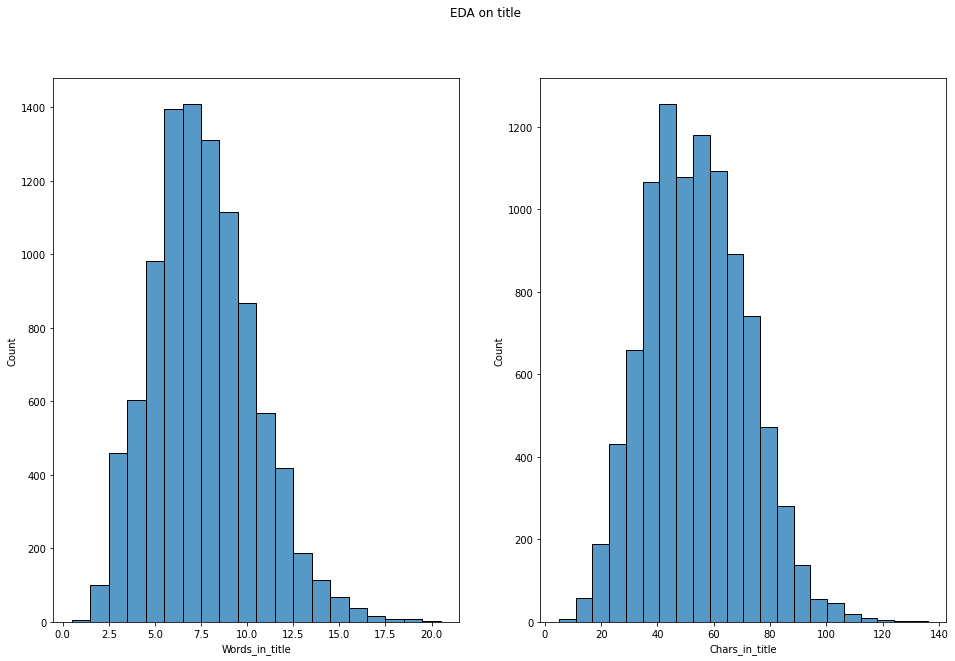

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (16, 10))
fig.suptitle('EDA on title')

sns.histplot(ax = axes[0], x = papers_updated.Words_in_title, discrete = True)
sns.histplot(ax = axes[1], x = papers_updated.Chars_in_title, bins = 22)

**Observation 1:** The titles seem to have around 6 to 8 words on average.  
**Observation 2:** The titles seem to have around 34 to 58 characters on average.

<AxesSubplot:xlabel='Chars_in_text', ylabel='Count'>

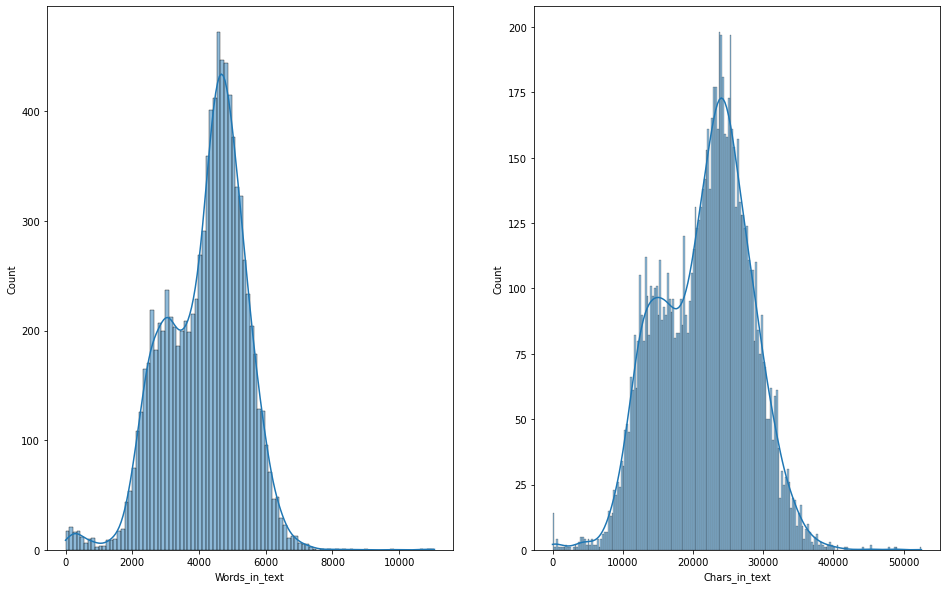

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (16, 10))
sns.histplot(ax = axes[0], x = papers_updated.Words_in_text, bins = 100, kde = True)
sns.histplot(ax = axes[1], x = papers_updated.Chars_in_text, bins = 200, kde = True)

**Observation 3:** The full texts seems to have around 4500 to 6000 words on average (just a guess).  
**Observation 4:** The full texts seem to have around 22250 to 27500 characters on average.

### 2.1. Top words in the `title` and `abstract`

All frequencies, including STOPWORDS:
            Word  Frequency
0            for       2840
1             of       2289
2       learning       2161
3            and       1676
4              a       1439
5           with       1422
6             in       1364
7            the       1195
8         neural        907
9       networks        862
10            to        700
11        models        611
12         using        549
13            on        537
14         model        450
15          from        412
16          deep        389
17           via        375
18      bayesian        369
19  optimization        352
20          data        351
21       network        338
22     inference        326
23            by        299
24      analysis        294


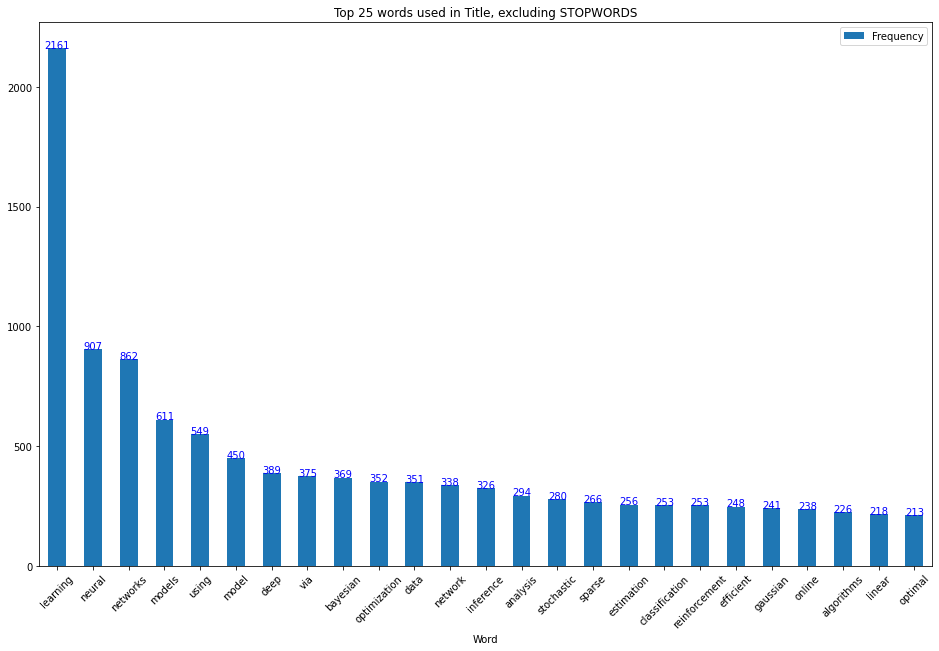

In [28]:
top_N = 25

txt = papers_updated.title.str.cat(sep = ' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot = 45, figsize = (16, 10), title = 'Top 25 words used in Title, excluding STOPWORDS')

for i, v in enumerate(rslt.Frequency):
    plt.text(i, v, "" + str(v), color = 'blue', horizontalalignment = 'center')

All frequencies, including STOPWORDS:
        Word  Frequency
0        the      98986
1         of      59870
2          a      47186
3        and      39005
4         to      37942
5         in      32441
6         we      26664
7         is      25793
8        for      21183
9       that      21154
10        on      14472
11      this      13467
12      with      12972
13        as      11092
14       are      10810
15        by      10483
16        an       9499
17  learning       8666
18        be       8652
19       can       8554
20       our       7748
21     model       7740
22      from       7469
23     which       7230
24      data       6740


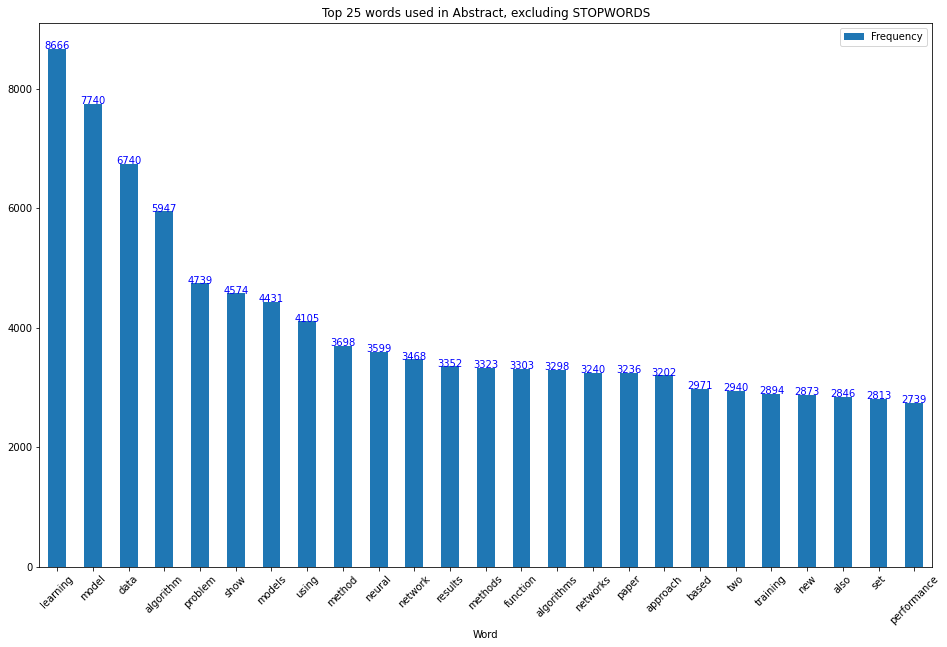

In [29]:
top_N = 25

txt = papers_updated.abstract.str.cat(sep = ' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt.plot.bar(rot = 45, figsize = (16, 10), title = 'Top 25 words used in Abstract, excluding STOPWORDS')

for i, v in enumerate(rslt.Frequency):
    plt.text(i, v, "" + str(v), color = 'blue', horizontalalignment = 'center')

**Observation 5:** Some of the common words used in both the title and the abstract are: 
$$\text{Model, Neural, Algorithm, Learning, Network, Data}$$

# 3. Topic modelling

From [here](https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/4-Topic-Modeling.ipynb):
> A popular text analysis technique is called **topic modelling**. The ultimate goal of topic modelling is to find various topics that are present in our corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics. We will be doing Latent Dirichlet Allocation (LDA), one of many topic modelling techniques specifically designed for text data.

> To use a topic modelling technique, we need to provide: (1) a document-term matrix and (2) the number of topics we would like the algorithm to pick up. Once the topic modelling technique is applied, our job as a human is to interpret the results and see if the mix of words in each topic make sense. If they don't make sense, we can try changing the number of topics, the terms in the document-term matrix, model parameters, or even try a different model.

In [30]:
# Import the necessary modules for LDA with gensim
from gensim import matutils, models
import scipy.sparse

import logging
# Display progress logs on stdout
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [31]:
# We create a document-term matrix using CountVectorizer excluding common English stop words
# Additionally use unigrams, bigrams and trigrams ignoring words that appear only in 1 document
# Also, use only the top 2500 features (these are ordered by term frequency across the corpus)
from sklearn.feature_extraction.text import CountVectorizer

# Use raw term count features for LDA. LDA has TF-IDF built in, so we need to use a CountVectorizer 
# as the vectorizer instead of a TfidfVectorizer.
cv = CountVectorizer(stop_words = 'english', min_df = 2, ngram_range = (1, 3), max_features = 2500)
data_cv = cv.fit_transform(papers_updated.full_text)

data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = papers_updated.index

data_dtm.head()

,aaai,ab,ability,able,absolute,abstract,accelerated,access,according,account,...,ﬁrst,ﬁrstorder,ﬁt,ﬁtting,ﬁve,ﬁx,ﬁxed,ﬁxed point,ﬂexible,ﬂow
0,0,0,2,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,6,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Term-document matrix
tdm = data_dtm.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,9670,9671,9672,9673,9674,9675,9676,9677,9678,9679
aaai,0,0,0,0,0,0,0,0,0,0,...,6,2,0,0,1,0,0,0,0,0
ab,0,0,0,0,0,0,0,0,0,0,...,2,2,0,2,0,0,0,1,0,0
ability,2,2,1,6,0,0,0,0,5,3,...,0,0,0,1,1,1,0,0,0,1
able,1,0,0,5,0,2,3,1,5,0,...,1,0,0,0,0,0,0,1,0,0
absolute,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [33]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [34]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

Now that we have the `corpus` (term-document matrix) and `id2word` (dictionary of location: term), we need to specify two other parameters - the number of topics and the number of passes.  
***
**Note:** We are modelling the topics using `full_text` of `papers_updated` dataset.

In [35]:
lda = models.LdaModel(corpus = corpus, id2word = id2word, num_topics = 15, passes = 40)
lda.print_topics()

[(0,
  '0.039*"algorithm" + 0.019*"regret" + 0.014*"bound" + 0.013*"online" + 0.011*"time" + 0.011*"problem" + 0.011*"arm" + 0.010*"game" + 0.010*"learning" + 0.010*"bandit"'),
 (1,
  '0.030*"network" + 0.022*"input" + 0.016*"neural" + 0.013*"unit" + 0.013*"output" + 0.012*"function" + 0.011*"weight" + 0.011*"neuron" + 0.011*"time" + 0.010*"learning"'),
 (2,
  '0.059*"network" + 0.029*"training" + 0.029*"layer" + 0.022*"neural" + 0.021*"deep" + 0.019*"neural network" + 0.019*"learning" + 0.011*"architecture" + 0.011*"weight" + 0.010*"model"'),
 (3,
  '0.038*"model" + 0.019*"word" + 0.016*"task" + 0.011*"language" + 0.010*"set" + 0.010*"sequence" + 0.009*"topic" + 0.009*"user" + 0.009*"data" + 0.008*"domain"'),
 (4,
  '0.063*"image" + 0.025*"object" + 0.021*"feature" + 0.012*"model" + 0.010*"recognition" + 0.010*"vision" + 0.009*"visual" + 0.008*"pixel" + 0.008*"map" + 0.008*"using"'),
 (5,
  '0.036*"policy" + 0.032*"state" + 0.026*"learning" + 0.020*"agent" + 0.019*"action" + 0.018*"re

In [36]:
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. Lower the better.


Perplexity:  -6.949021717311965


Follow the code cells 20-27 [here](https://www.kaggle.com/ktakuma/topic-modeling-of-ml-papers-with-lda?rvi=1) to get the answers to:  
$\text{1. How have the dominant topics varied since 1987?}$  
<a href="https://ibb.co/m5SBTLB"><center><img src="https://i.ibb.co/9HGvgFv/Capture.jpg" alt="Capture" border="0" /></center></a>  

$\text{2. What are the most frequent words in each topic (analyzed through a WordCloud)?}$  
<a href="https://ibb.co/THNwkWr"><center><img src="https://i.ibb.co/2jpFyZ5/plot.jpg" alt="plot" border="0"></center></a>

# 4. Clustering

Read [this article](https://towardsdatascience.com/a-friendly-introduction-to-text-clustering-fa996bcefd04) for a info-packed introduction to text clustering.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Process text
def identity_tokenizer(text):
    return text

In [38]:
tfidf = TfidfVectorizer(stop_words = 'english', min_df = 2, tokenizer = identity_tokenizer, ngram_range = (1, 3), max_features = 2500)
processed_docs_tfidf = tfidf.fit_transform(papers_updated.full_text)
processed_docs_tfidf.shape

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(9680, 2500)

In [39]:
from sklearn.cluster import KMeans

num_clusters = 15
km = KMeans(n_clusters = num_clusters, max_iter = 1000)
km.fit(processed_docs_tfidf)
clusters = km.labels_.tolist()

In [40]:
sour = papers_updated.source_id.values
mapping = dict(zip(sour,clusters))
papers_updated["Cluster"] = papers_updated.source_id.map(mapping)
papers_updated.head()

,source_id,year,title,abstract,full_text,Words_in_title,Chars_in_title,Avg_chars_in_title,Words_in_text,Chars_in_text,Avg_chars_in_text,Cluster
0,27,1987,bitserial neural networks,a bit serial vlsi neural network is described from an ...,the function a synthetic neural network may aspire to mimic are th...,3,23,7.666667,3276,16564,5.056166,0
1,63,1987,connectivity versus entropy,how does the connectivity of a neural network number of s...,the most distinguishing feature of neural network is their ability...,3,25,8.333333,1221,5634,4.614251,8
2,60,1987,the hopfield model with multilevel neurons,the hopfield neural network model for associative memory ...,the ability to perfonn collective computation in a distributed sys...,6,37,6.166667,1914,7916,4.135841,8
3,59,1987,how neural nets work,there is presently great interest in the abilities of neural net...,alan lapedes robert farber theoretical division how neural net wor...,4,17,4.250000,5190,24447,4.710405,8
4,69,1987,spatial organization of neural networks a probabilistic modeling a...,the aim of this paper is to explore the spatial organiz...,neural net model have been studied for many year in an attempt to ...,9,65,7.222222,2831,13934,4.921936,0


In [41]:
papers_updated['Cluster'].value_counts()

8     2631
11    1658
1     1425
0     1161
12     962
2      887
4      590
7      229
5       91
6       19
3       10
9        7
14       6
13       4
Name: Cluster, dtype: int64

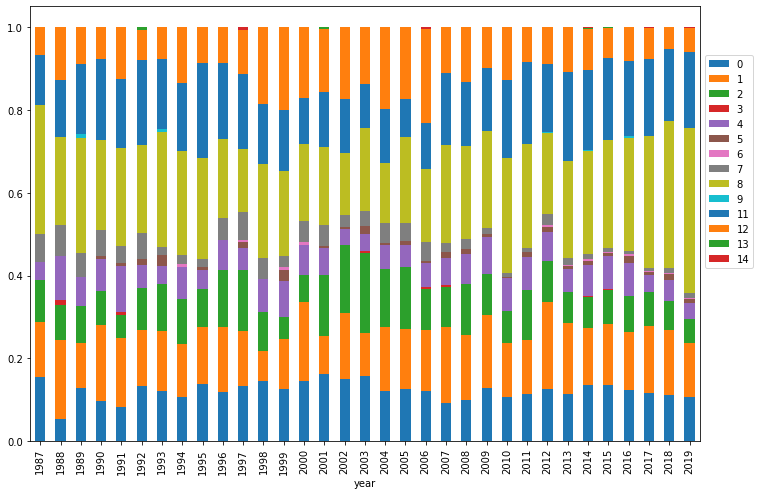

In [42]:
# Create a plot similar to that in question 2 above.
plt.rcParams['figure.figsize'] = (12,8)
pd.crosstab(papers_updated['year'], papers_updated['Cluster'], normalize = 'index').plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 0.9))
ax = plt.subplot()
plt.show()